

# Challenge Ingredion - Sprint 2
Este notebook foi desenvolvido para o Challenge em parceria com a Ingredion, na Sprint 2.

### Aplicação da Técnica de Segmentação - SAM



**Célula** 0: Montar Google Drive

In [ ]:
# Montar Google Drive (Necessário no Colab para acessar/salvar arquivos no Drive)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive montado com sucesso.")
    # Verificar se os diretórios de dados existem (opcional, mas útil)
except ModuleNotFoundError:
    print("Não está no ambiente Google Colab ou erro ao montar Drive.")
    # Se não estiver no Colab, ajuste os caminhos para serem locais

**Célula** 0: Instalar pacotes

In [ ]:
!pip install torch torchvision albumentations opencv-python-headless matplotlib numpy pandas seaborn scikit-learn

**Célula** 1: Instalação, Imports e Configurações

In [110]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A

from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split # Para divisão treino/teste

# Imports dos modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Imports de métricas e plotagem
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Configurações e Caminhos ---
DRIVE_BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data"

if not os.path.isdir(DRIVE_BASE_PATH):
  print(f"Aviso: Diretório base '{DRIVE_BASE_PATH}' não encontrado no Drive. Verifique os caminhos.")

IMAGE_TRAIN_DIR = os.path.join(DRIVE_BASE_PATH, "train/images")
MASK_TRAIN_DIR = os.path.join(DRIVE_BASE_PATH, "train/masks")
IMAGE_VAL_DIR = os.path.join(DRIVE_BASE_PATH, "val/images")
MASK_VAL_DIR = os.path.join(DRIVE_BASE_PATH, "val/masks")
IMAGE_TEST_DIR = os.path.join(DRIVE_BASE_PATH, "test/images")
MASK_TEST_DIR = os.path.join(DRIVE_BASE_PATH, "test/masks")

PROD_CSV_PATH = os.path.join(DRIVE_BASE_PATH, "Producao.csv")
NDVI_CSV_PATH = os.path.join(DRIVE_BASE_PATH, "NDVI.csv")

# Caminho para salvar o melhor modelo de segmentação
# Salvar no Drive é recomendado para persistência entre sessões do Colab
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/output"
os.makedirs(SAVE_DIR, exist_ok=True) # Cria o diretório se não existir
BEST_MODEL_PATH = os.path.join(SAVE_DIR, 'best_segmentation_model.pth')

# Parâmetros de Treinamento (Segmentação)
NUM_EPOCHS_SEGMENTATION = 10 # AJUSTE
BATCH_SIZE_SEGMENTATION = 64
LEARNING_RATE_SEGMENTATION = 3e-4

# Parâmetros de Modelagem (Previsão de Rendimento)
RANDOM_STATE = 42
N_ESTIMATORS_RF = 200
TEST_YEARS_SPLIT = 10 # Número de anos recentes para usar como teste

# Configuração do dispositivo (GPU ou CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {DEVICE}")

Usando dispositivo: cuda


Célula 2: Célula para Geração Dinâmica de Máscaras

In [111]:
# Célula para Geração Dinâmica de Máscaras (Otsu com Verificação de Existência)

# --- Diretórios (Definidos na Célula 1) ---
print("--- Iniciando Geração Dinâmica de Máscaras (Método de Otsu com Verificação) ---")

# Lista de pares de diretórios (entrada de imagens, saída de máscaras)
dir_pairs = [
    (IMAGE_TRAIN_DIR, MASK_TRAIN_DIR),
    (IMAGE_VAL_DIR, MASK_VAL_DIR),
    (IMAGE_TEST_DIR, MASK_TEST_DIR)
]

total_images_processed = 0
total_errors = 0
total_skipped = 0 # Contador para imagens puladas
start_time = time.time()

# Loop pelos pares de diretórios (train, val, test)
for img_dir, mask_dir in dir_pairs:
    print(f"\nProcessando diretório: {img_dir}")

    if not os.path.isdir(img_dir):
        print(f"Aviso: Diretório de entrada não encontrado: {img_dir}. Pulando.")
        continue

    try:
        os.makedirs(mask_dir, exist_ok=True)
    except OSError as e:
        print(f"Erro ao criar diretório de saída {mask_dir}: {e}. Pulando este diretório.")
        continue

    try:
        image_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
        print(f"Encontradas {len(image_files)} imagens .jpg.")
    except Exception as e:
        print(f"Erro ao listar arquivos em {img_dir}: {e}. Pulando este diretório.")
        continue

    if not image_files:
        print("Nenhuma imagem .jpg encontrada para processar.")
        continue

    # Loop por cada imagem no diretório atual
    for img_filename in image_files:
        image_path = os.path.join(img_dir, img_filename)

        # --- INÍCIO DA VERIFICAÇÃO ---
        # Construir o nome e caminho esperado para a máscara de saída
        mask_filename = os.path.splitext(img_filename)[0] + "_mask.png"
        save_path = os.path.join(mask_dir, mask_filename)

        # Verificar se a máscara já existe
        if os.path.exists(save_path):
            # print(f"  Máscara já existe para {img_filename}. Pulando.") # Descomente se quiser log detalhado
            total_skipped += 1
            continue # Pula para a próxima imagem no loop interno
        # --- FIM DA VERIFICAÇÃO ---

        # Se a máscara não existe, processa a imagem
        try:
            img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                if not os.path.exists(image_path):
                   print(f"Erro: Arquivo não encontrado {image_path}. Pulando.")
                else:
                   print(f"Erro: Imagem não pode ser lida ou está vazia: {img_filename}. Pulando.")
                total_errors += 1
                continue

            # Aplicar Binarização de Otsu
            ret_otsu, mask_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Salvar a máscara gerada
            success = cv2.imwrite(save_path, mask_otsu)
            if not success:
                print(f"Erro ao salvar máscara para {img_filename} em {save_path}. Pulando.")
                total_errors += 1
                continue

            total_images_processed += 1
            if total_images_processed % 50 == 0:
                print(f"  {total_images_processed} novas máscaras geradas...")

        except Exception as e:
            print(f"Erro ao processar imagem {img_filename}: {e}. Pulando.")
            total_errors += 1

    print(f"Diretório {img_dir} concluído.")

end_time = time.time()
elapsed_time = end_time - start_time

print("\n--- Processamento Concluído ---")
print(f"Total de NOVAS máscaras geradas: {total_images_processed}")
print(f"Total de imagens PULADAS (máscara já existia): {total_skipped}")
print(f"Total de erros encontrados durante o processamento: {total_errors}")
print(f"Tempo total: {elapsed_time:.2f} segundos")
print(f"Máscaras salvas (ou verificadas) nos diretórios: {MASK_TRAIN_DIR}, {MASK_VAL_DIR}, {MASK_TEST_DIR}")

--- Iniciando Geração Dinâmica de Máscaras (Método de Otsu com Verificação) ---

Processando diretório: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/train/images
Encontradas 4 imagens .jpg.
Diretório /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/train/images concluído.

Processando diretório: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/val/images
Encontradas 3 imagens .jpg.
Diretório /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/val/images concluído.

Processando diretório: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/test/images
Encontradas 3 imagens .jpg.
Diretório /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/test/images concluído.

--- Processamento Concluído ---
Total de NOVAS máscaras geradas: 7
Total de imagens PULADAS (máscara já existia): 3
Total de erros encontrados durante o process

Célula 3: Definição da Classe

In [112]:
# Classe Dataset para carregar imagens e máscaras de segmentação
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Filtrar para garantir que estamos lendo apenas arquivos de imagem esperados (ex: .jpg)
        try:
          self.images = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]
        except FileNotFoundError:
          print(f"Erro: Diretório de imagens não encontrado: {image_dir}")
          self.images = []
          # Levantar erro ou tratar como apropriado
          # raise

        # Verifique se todos os arquivos têm máscaras correspondentes
        missing_masks = []
        valid_images = []
        if self.images: # Procede apenas se encontrou imagens
            for img_name in self.images:
                mask_name = img_name.replace(".jpg", "_mask.png") # Assumindo convenção _mask.png
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    valid_images.append(img_name)
                else:
                    missing_masks.append(mask_path)

            if missing_masks:
                print(f"Aviso: Máscaras não encontradas para {len(missing_masks)} imagens em {mask_dir}.")
                # print(f"Exemplos de máscaras faltando: {missing_masks[:5]}") # Descomente para debug
            self.images = valid_images # Use only images with corresponding masks
        else:
            print(f"Nenhuma imagem .jpg encontrada em {image_dir}")


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if not self.images: return None, None # Lida com caso de diretório vazio

        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace(".jpg", "_mask.png")
        mask_path = os.path.join(self.mask_dir, mask_name)

        try:
            image = cv2.imread(img_path)
            if image is None:
                # Tentar carregar mesmo se nome tiver case diferente (comum em alguns sistemas)
                if not os.path.exists(img_path):
                   raise FileNotFoundError(f"Arquivo de imagem não encontrado: {img_path}")
                raise ValueError(f"Imagem não pode ser lida ou está vazia: {img_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                 # Tentar carregar mesmo se nome tiver case diferente
                 if not os.path.exists(mask_path):
                    raise FileNotFoundError(f"Arquivo de máscara não encontrado: {mask_path}")
                 raise ValueError(f"Máscara não pode ser lida ou está vazia: {mask_path}")

            # Normalizar máscara para 0 ou 1 (assumindo valores originais 0 e 255)
            mask = (mask > 128).astype(np.float32) # Convert to 0.0 or 1.0

            # Aplicar transformações
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Converter para Tensor PyTorch CHW (se a transform não o fez)
            # A.Normalize geralmente retorna numpy HWC; A.ToTensorV2 retorna tensor CHW
            if isinstance(image, np.ndarray):
                 # Normalização geralmente resulta em float32 HWC
                 image = torch.from_numpy(image).permute(2, 0, 1)
            if isinstance(mask, np.ndarray):
                 # Máscara é HW, converter para tensor float
                 mask = torch.from_numpy(mask).float()

        except Exception as e:
            print(f"Erro ao carregar item {idx} ({img_name}): {e}")
            return None, None # Retorna None para ser tratado pelo collate_fn

        return image, mask

print("Classe SatelliteDataset definida.")

Classe SatelliteDataset definida.


Célula 4: Transformações e DataLoaders (Segmentação)

In [113]:
# Transformações (usando médias/std da ImageNet)
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    # Se não usar ToTensorV2, a conversão para Tensor e permuta é feita no __getitem__
])

val_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Criar Datasets e DataLoaders
try:
    train_dataset = SatelliteDataset(IMAGE_TRAIN_DIR, MASK_TRAIN_DIR, train_transform)
    val_dataset = SatelliteDataset(IMAGE_VAL_DIR, MASK_VAL_DIR, val_transform)
    test_dataset = SatelliteDataset(IMAGE_TEST_DIR, MASK_TEST_DIR, val_transform)

    # Função collate para lidar com possíveis Nones retornados por __getitem__
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
        if not batch: return None # Retorna None se o batch inteiro falhar
        return torch.utils.data.dataloader.default_collate(batch)

    # Verificar se os datasets foram criados com sucesso antes de criar DataLoaders
    if len(train_dataset) > 0:
       train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_SEGMENTATION, shuffle=True, num_workers=2, collate_fn=collate_fn, pin_memory=True)
       print(f"Train DataLoader criado com {len(train_dataset)} imagens.")
    else:
       train_loader = None
       print(f"Aviso: Train dataset vazio ou não pôde ser carregado de {IMAGE_TRAIN_DIR}. DataLoader de treino não criado.")

    if len(val_dataset) > 0:
       val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_SEGMENTATION, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)
       print(f"Validation DataLoader criado com {len(val_dataset)} imagens.")
    else:
       val_loader = None
       print(f"Aviso: Validation dataset vazio ou não pôde ser carregado de {IMAGE_VAL_DIR}. DataLoader de validação não criado.")

    if len(test_dataset) > 0:
      test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True) # Batch size 1 para teste/inferência
      print(f"Test DataLoader criado com {len(test_dataset)} imagens.")
    else:
      test_loader = None
      print(f"Aviso: Test dataset vazio ou não pôde ser carregado de {IMAGE_TEST_DIR}. DataLoader de teste não criado.")


except Exception as e:
    print(f"Erro ao criar Datasets/DataLoaders de segmentação: {e}")
    # Considerar parar a execução se os loaders não puderem ser criados
    # raise e

print("\nTransformações e DataLoaders definidos.")

Train DataLoader criado com 4 imagens.
Validation DataLoader criado com 3 imagens.
Test DataLoader criado com 3 imagens.

Transformações e DataLoaders definidos.


Célula 5: Definição do Modelo de Segmentação

In [114]:
# 1. Obtenha os pesos pré-treinados recomendados (DEFAULT)
weights = DeepLabV3_ResNet50_Weights.DEFAULT

# 2. Carregue o modelo DeepLabV3 pré-treinado usando o parâmetro 'weights'
model_segmentation = deeplabv3_resnet50(weights=weights)

# ----- Fim da Correção -----

# Modificar a última camada para 1 classe de saída (segmentação binária)
# A estrutura para acessar a camada final (classifier[4]) geralmente é estável,
# mas se encontrar erro aqui após atualizar, verifique a estrutura do modelo (print(model_segmentation))
model_segmentation.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

# Mover o modelo para o dispositivo (GPU ou CPU)
# Certifique-se que DEVICE está definido em alguma célula anterior
model_segmentation = model_segmentation.to(DEVICE)

# Definir Loss e Optimizer
criterion_segmentation = nn.BCEWithLogitsLoss() # Correto para saída binária com logits
# Certifique-se que LEARNING_RATE_SEGMENTATION está definido em alguma célula anterior
optimizer_segmentation = optim.Adam(model_segmentation.parameters(), lr=LEARNING_RATE_SEGMENTATION)

# Certifique-se que BEST_MODEL_PATH está definido em alguma célula anterior
print("Modelo de segmentação DeepLabV3+ definido com pesos atualizados e movido para o dispositivo.")
print(f"Caminho para salvar melhor modelo: {BEST_MODEL_PATH}")

Modelo de segmentação DeepLabV3+ definido com pesos atualizados e movido para o dispositivo.
Caminho para salvar melhor modelo: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/output/best_segmentation_model.pth


Célula 6: Função de Cálculo IoU (Segmentação)

In [115]:
# Função para calcular Intersection over Union (IoU)
def calculate_iou(pred, target, threshold=0.5):
    """Calcula IoU para segmentação binária usando tensores PyTorch."""
    # Garantir que os tensores estão na CPU e são do tipo float para operações
    pred = pred.detach().cpu().float()
    target = target.detach().cpu().float()

    pred_bool = (pred > threshold)
    target_bool = (target > 0.5) # Mascaras já devem ser 0 ou 1

    intersection = torch.logical_and(pred_bool, target_bool).sum().float()
    union = torch.logical_or(pred_bool, target_bool).sum().float()

    # Adicionar epsilon para evitar divisão por zero se a união for 0
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

print("Função calculate_iou definida.")

Função calculate_iou definida.


Célula 7: Treinamento do Modelo de Segmentação

In [116]:
# Verificar se o train_loader e val_loader foram criados
if train_loader and val_loader:
    print(f"\n--- Iniciando Treinamento ({NUM_EPOCHS_SEGMENTATION} épocas) ---")
    best_val_iou = -1.0 # Iniciar com valor baixo

    for epoch in range(NUM_EPOCHS_SEGMENTATION):
        model_segmentation.train()
        train_loss = 0.0
        train_iou = 0.0
        processed_batches_train = 0

        for batch in train_loader:
            if batch is None: continue # Pular batch inválido

            images, masks = batch
            images, masks = images.to(DEVICE), masks.to(DEVICE)

            # Garantir que a máscara tenha o shape correto [B, H, W]
            if masks.dim() == 4 and masks.shape[1] == 1:
                 masks = masks.squeeze(1)

            # Forward pass
            outputs = model_segmentation(images)['out'] # Shape [B, 1, H, W]
            loss = criterion_segmentation(outputs.squeeze(1), masks) # Squeeze output para [B, H, W]

            # Backward pass e otimização
            optimizer_segmentation.zero_grad()
            loss.backward()
            optimizer_segmentation.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs.squeeze(1))
            train_iou += calculate_iou(preds, masks) # Passar tensores diretamente
            processed_batches_train += 1

        avg_train_loss = train_loss / processed_batches_train if processed_batches_train > 0 else 0
        avg_train_iou = train_iou / processed_batches_train if processed_batches_train > 0 else 0

        # Validação
        model_segmentation.eval()
        val_loss = 0.0
        val_iou = 0.0
        processed_batches_val = 0
        with torch.no_grad():
            for batch in val_loader:
                if batch is None: continue
                images, masks = batch
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                if masks.dim() == 4 and masks.shape[1] == 1:
                     masks = masks.squeeze(1)

                outputs = model_segmentation(images)['out']
                loss = criterion_segmentation(outputs.squeeze(1), masks)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs.squeeze(1))
                val_iou += calculate_iou(preds, masks)
                processed_batches_val += 1

        avg_val_loss = val_loss / processed_batches_val if processed_batches_val > 0 else 0
        avg_val_iou = val_iou / processed_batches_val if processed_batches_val > 0 else 0

        print(f'Epoch {epoch+1}/{NUM_EPOCHS_SEGMENTATION} | '
              f'Train Loss: {avg_train_loss:.4f} | Train IoU: {avg_train_iou:.4f} | '
              f'Val Loss: {avg_val_loss:.4f} | Val IoU: {avg_val_iou:.4f}')

        # Salvar o melhor modelo
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            try:
                torch.save(model_segmentation.state_dict(), BEST_MODEL_PATH)
                print(f'---> Modelo salvo em {BEST_MODEL_PATH} (Melhor Val IoU: {best_val_iou:.4f})')
            except Exception as e:
                print(f"Erro ao salvar o modelo em {BEST_MODEL_PATH}: {e}")

    print("\n--- Treinamento de segmentação concluído. ---")
else:
    print("\n--- Treinamento de segmentação pulado pois DataLoaders não foram criados corretamente. ---")


--- Iniciando Treinamento (10 épocas) ---
Epoch 1/10 | Train Loss: 0.7200 | Train IoU: 0.3675 | Val Loss: 0.9069 | Val IoU: 0.2873
---> Modelo salvo em /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/output/best_segmentation_model.pth (Melhor Val IoU: 0.2873)
Epoch 2/10 | Train Loss: 0.6448 | Train IoU: 0.4879 | Val Loss: 0.9818 | Val IoU: 0.2872
Epoch 3/10 | Train Loss: 0.6028 | Train IoU: 0.5083 | Val Loss: 0.9720 | Val IoU: 0.2959
---> Modelo salvo em /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/output/best_segmentation_model.pth (Melhor Val IoU: 0.2959)
Epoch 4/10 | Train Loss: 0.5354 | Train IoU: 0.5702 | Val Loss: 1.0452 | Val IoU: 0.3039
---> Modelo salvo em /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/output/best_segmentation_model.pth (Melhor Val IoU: 0.3039)
Epoch 5/10 | Train Loss: 0.5001 | Train IoU: 0.5810 | Val Loss: 1.1756 | Val IoU: 0.3063
---> Modelo salvo em /content/drive/MyDrive/Colab 

Célula 8: Avaliação do Modelo de Segmentação (Test Set)

In [117]:
# Verificar se o test_loader existe e se o modelo foi salvo
if test_loader and os.path.exists(BEST_MODEL_PATH):
    print("\n--- Avaliando Melhor Modelo de Segmentação no Conjunto de Teste ---")
    try:
        # Carregar o melhor modelo salvo
        model_segmentation.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE)) # Usar map_location
        model_segmentation.eval()

        test_loss = 0.0
        test_iou = 0.0
        processed_batches_test = 0

        with torch.no_grad():
            for batch in test_loader:
                if batch is None: continue
                images, masks = batch
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                if masks.dim() == 4 and masks.shape[1] == 1:
                    masks = masks.squeeze(1)

                outputs = model_segmentation(images)['out']
                # Tratamento para caso raro de output não ter a dimensão esperada
                if outputs.dim() == 4 and outputs.shape[1] == 1:
                   outputs_squeezed = outputs.squeeze(1)
                else:
                   # Lidar com caso inesperado, talvez pular o batch
                   print(f"Aviso: Shape de output inesperado: {outputs.shape}")
                   continue

                loss = criterion_segmentation(outputs_squeezed, masks)
                test_loss += loss.item()

                preds = torch.sigmoid(outputs_squeezed)
                test_iou += calculate_iou(preds, masks)
                processed_batches_test += 1

        if processed_batches_test > 0:
          avg_test_loss = test_loss / processed_batches_test
          avg_test_iou = test_iou / processed_batches_test
          print(f'Resultados no Teste: Loss: {avg_test_loss:.4f} | IoU: {avg_test_iou:.4f}')
        else:
            print("Nenhum batch de teste pôde ser processado.")

    except FileNotFoundError:
        print(f"Erro: Melhor modelo de segmentação não encontrado em {BEST_MODEL_PATH}.")
    except Exception as e:
        print(f"Erro durante a avaliação no teste de segmentação: {e}")
else:
    if not test_loader: print("\n--- Avaliação de teste pulada: Test DataLoader não disponível.")
    if not os.path.exists(BEST_MODEL_PATH): print(f"\n--- Avaliação de teste pulada: Modelo {BEST_MODEL_PATH} não encontrado.")


--- Avaliando Melhor Modelo de Segmentação no Conjunto de Teste ---
Resultados no Teste: Loss: 0.7803 | IoU: 0.3698


Célula 9: Função de Predição e Visualização (Segmentação)


--- Visualizando Exemplo de Predição de Segmentação ---


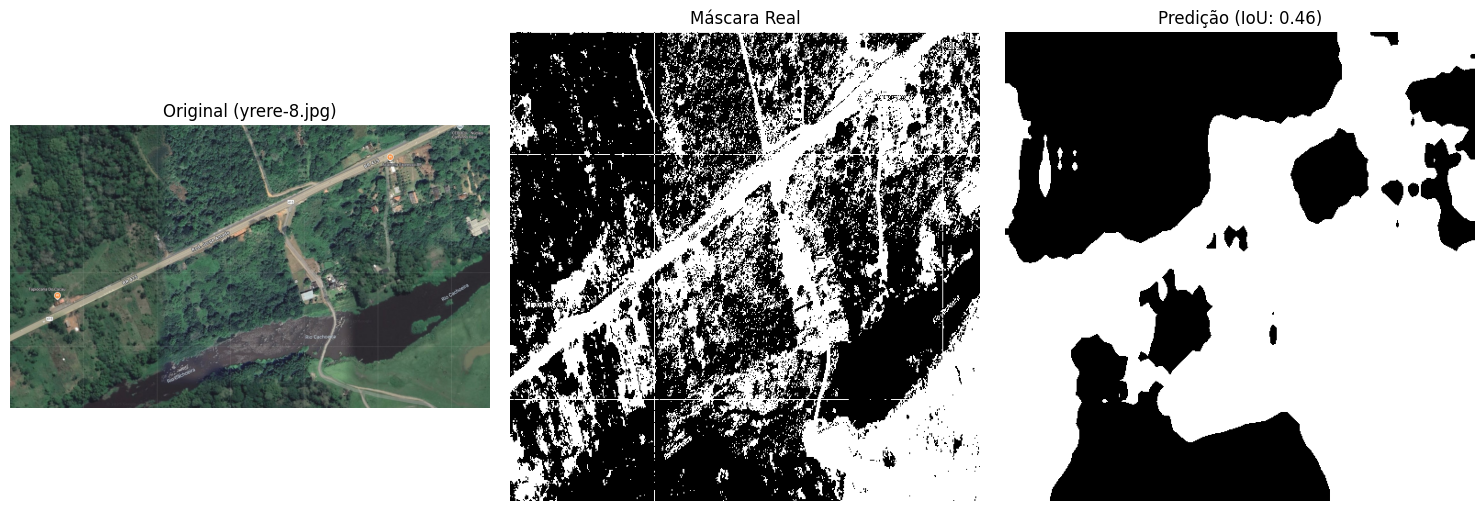

In [118]:
# Função para prever máscara de uma imagem individual
def predict_single_image(image_path, model, device, transform):
    """Prevê a máscara de segmentação para um único arquivo de imagem."""
    if not os.path.exists(image_path):
        print(f"Aviso: Arquivo não encontrado: {image_path}")
        return None, None # Retorna None se o arquivo não existe

    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Falha ao ler a imagem: {image_path}")
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Aplicar transformações de validação/teste
        augmented = transform(image=image_rgb)
        input_image_transformed = augmented['image']

        # Converter para tensor CHW
        if isinstance(input_image_transformed, np.ndarray):
            input_tensor = torch.from_numpy(input_image_transformed).permute(2, 0, 1).float()
        elif isinstance(input_image_transformed, torch.Tensor):
            input_tensor = input_image_transformed.float()
            if input_tensor.dim() == 3 and input_tensor.shape[2] == 3:
                 input_tensor = input_tensor.permute(2, 0, 1)
        else:
             raise TypeError("Tipo de saída inesperado da transformação.")

        input_tensor = input_tensor.unsqueeze(0).to(device)

        # Predição
        model.eval()
        with torch.no_grad():
            output = model(input_tensor)['out'].squeeze(0) # Remove B dim -> [C, H, W]

        # Processa a saída para máscara binária NumPy
        # Remove C dim (era 1), aplica sigmoid, threshold, move para CPU, numpy
        pred_mask = (torch.sigmoid(output.squeeze(0)) > 0.5).cpu().numpy()

    except Exception as e:
        print(f"Erro ao prever imagem {image_path}: {e}")
        return None, None

    return pred_mask, image_rgb

# Visualizar um exemplo do conjunto de teste (se disponível)
if test_dataset and len(test_dataset) > 0 and os.path.exists(BEST_MODEL_PATH):
    print("\n--- Visualizando Exemplo de Predição de Segmentação ---")
    try:
        # Carregar modelo (caso não esteja carregado)
        if 'model_segmentation' not in locals() or model_segmentation is None:
             model_segmentation = deeplabv3_resnet50(pretrained=False) # Não precisa pré-treinado aqui
             model_segmentation.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
             model_segmentation.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
             model_segmentation = model_segmentation.to(DEVICE)
             model_segmentation.eval()

        # Obter item de teste
        item_idx = 0 # Pega o primeiro item
        test_image_name = test_dataset.images[item_idx]
        test_image_path = os.path.join(IMAGE_TEST_DIR, test_image_name)

        # Obter máscara real do dataset (já processada)
        _, mask_real_tensor = test_dataset[item_idx]
        if mask_real_tensor is not None:
           mask_real_np = mask_real_tensor.cpu().numpy() # Converte para numpy

           # Fazer a predição
           pred_mask_np, original_image_np = predict_single_image(
               test_image_path, model_segmentation, DEVICE, val_transform
           )

           if pred_mask_np is not None:
              # Calcular IoU para este exemplo
              iou_example = calculate_iou(torch.tensor(pred_mask_np), torch.tensor(mask_real_np))

              # Plot
              plt.figure(figsize=(15, 5))
              plt.subplot(1, 3, 1)
              plt.imshow(original_image_np)
              plt.title(f'Original ({test_image_name})')
              plt.axis('off')

              plt.subplot(1, 3, 2)
              plt.imshow(mask_real_np, cmap='gray')
              plt.title('Máscara Real')
              plt.axis('off')

              plt.subplot(1, 3, 3)
              plt.imshow(pred_mask_np, cmap='gray')
              plt.title(f'Predição (IoU: {iou_example:.2f})')
              plt.axis('off')
              plt.tight_layout()
              plt.show()
           else:
              print(f"Falha ao gerar predição para {test_image_path}")
        else:
            print(f"Falha ao obter máscara real para o item de teste {item_idx}")

    except IndexError:
        print("Índice fora do alcance no dataset de teste.")
    except Exception as e:
        print(f"Erro ao visualizar exemplo de segmentação: {e}")
else:
     print("\n--- Visualização de segmentação pulada (Dataset de teste ou modelo não disponível). ---")

Célula 10: Carregar e Pré-processar Dados Tabulares (Produtividade e NDVI)

In [119]:
print("\n--- Carregando e Processando Dados Tabulares ---")

# --- Carregar Produtividade ---
df_prod = None # Inicializa para verificar carregamento
try:
    df_prod = pd.read_csv(PROD_CSV_PATH)
    print(f"Arquivo de produtividade '{PROD_CSV_PATH}' carregado.")
    # Selecionar e renomear colunas
    cols_prod_to_keep = {
        'Ano': 'Ano',
        'Área colhida (Hectares)': 'Area_Colhida_ha',
        'Rendimento médio da produção (Quilogramas por Hectare)': 'Rendimento_Medio_kg_ha'
    }
    # Verifica se todas as colunas ORIGINAIS existem
    if all(col in df_prod.columns for col in cols_prod_to_keep.keys()):
        df_prod = df_prod[list(cols_prod_to_keep.keys())].copy()
        df_prod.rename(columns=cols_prod_to_keep, inplace=True)
        df_prod['Ano'] = df_prod['Ano'].astype(int)
        print("Dados de produtividade selecionados e limpos.")
        print("Head df_prod:")
        print(df_prod.head())
    else:
        print(f"Aviso: Colunas esperadas ({list(cols_prod_to_keep.keys())}) não encontradas em {PROD_CSV_PATH}")
        print(f"Colunas encontradas: {df_prod.columns.tolist()}")
        df_prod = None # Anula se não encontrar colunas

except FileNotFoundError:
    print(f"Erro Crítico: Arquivo de produtividade '{PROD_CSV_PATH}' não encontrado.")
except Exception as e:
    print(f"Erro Crítico ao processar produtividade: {e}")

# --- Carregar e Limpar NDVI ---
df_ndvi = None # Inicializa
if df_prod is not None: # Só tenta carregar NDVI se produtividade carregou
    try:
        df_ndvi = pd.read_csv(NDVI_CSV_PATH, header=2) # Usa header=2 conforme descoberto
        if len(df_ndvi.columns) >= 2:
            # Renomeia as duas primeiras colunas e seleciona
            df_ndvi = df_ndvi.iloc[:, :2].copy() # Pega só as duas primeiras colunas
            df_ndvi.columns = ['Data', 'NDVI']
            # Remove a linha que contém 'Data', 'NDVI' como valores
            df_ndvi = df_ndvi[df_ndvi['Data'] != 'Data'].reset_index(drop=True)
        else:
            raise ValueError("CSV NDVI não tem colunas suficientes após carregar com header=2.")

        # Converter tipos
        df_ndvi['Data'] = pd.to_datetime(df_ndvi['Data'], format='%d/%m/%Y', errors='coerce')
        df_ndvi.dropna(subset=['Data'], inplace=True)
        if df_ndvi['NDVI'].dtype == 'object':
           df_ndvi['NDVI'] = df_ndvi['NDVI'].astype(str).str.replace(',', '.', regex=False)
        df_ndvi['NDVI'] = pd.to_numeric(df_ndvi['NDVI'], errors='coerce')
        df_ndvi.dropna(subset=['NDVI'], inplace=True)
        df_ndvi['Ano'] = df_ndvi['Data'].dt.year
        print(f"Arquivo NDVI '{NDVI_CSV_PATH}' carregado e limpo.")
        print("Head df_ndvi:")
        print(df_ndvi.head())

    except FileNotFoundError:
        print(f"Erro Crítico: Arquivo NDVI '{NDVI_CSV_PATH}' não encontrado.")
        df_ndvi = None # Garante que está None se falhar
    except Exception as e:
        print(f"Erro Crítico ao processar NDVI: {e}")
        df_ndvi = None # Garante que está None se falhar
else:
    print("Carregamento de NDVI pulado pois o arquivo de produtividade não foi carregado.")


--- Carregando e Processando Dados Tabulares ---
Arquivo de produtividade '/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/Producao.csv' carregado.
Dados de produtividade selecionados e limpos.
Head df_prod:
    Ano  Area_Colhida_ha  Rendimento_Medio_kg_ha
0  1994            51583                     539
1  1995            59968                     390
2  1996            42320                     400
3  1997            60000                     400
4  1998            60109                     449
Arquivo NDVI '/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 6/Atividade - Challenge/data/NDVI.csv' carregado e limpo.
Head df_ndvi:
        Data    NDVI   Ano
0 2000-02-18  0.6520  2000
1 2000-03-05  0.7937  2000
2 2000-03-21  0.8264  2000
3 2000-04-06 -0.3000  2000
4 2000-04-22  0.7984  2000


Célula 11: Integração de Dados Tabulares e Engenharia de Features

In [120]:
# Verificar se ambos DataFrames foram carregados
if df_prod is not None and df_ndvi is not None:
    print("\n--- Integrando Dados e Criando Features ---")

    # Agregar NDVI por Ano
    max_prod_year = df_prod['Ano'].max()
    df_ndvi_filtered = df_ndvi[df_ndvi['Ano'] <= max_prod_year].copy()
    ndvi_threshold = 0.1 # Filtro para remover ruídos
    df_ndvi_filtered_positive = df_ndvi_filtered[df_ndvi_filtered['NDVI'] > ndvi_threshold]

    if not df_ndvi_filtered_positive.empty:
        df_ndvi_agg = df_ndvi_filtered_positive.groupby('Ano')['NDVI'].agg(
            ndvi_medio='mean', ndvi_max='max', ndvi_min='min', ndvi_std='std', ndvi_count='count'
        ).reset_index()
        df_ndvi_agg['ndvi_std'] = df_ndvi_agg['ndvi_std'].fillna(0) # Preenche std=0 se só 1 valor no ano
        print("NDVI agregado por ano.")
        print("Head df_ndvi_agg:")
        print(df_ndvi_agg.head())

        # Merge
        df_final = pd.merge(df_prod, df_ndvi_agg, on='Ano', how='left')
        print("\nMerge entre produtividade e NDVI realizado.")

        # Adicionar Features Lagged
        df_final['Rendimento_Medio_kg_ha_lag1'] = df_final['Rendimento_Medio_kg_ha'].shift(1)
        df_final['Area_Colhida_ha_lag1'] = df_final['Area_Colhida_ha'].shift(1)
        print("Features lagged adicionadas.")

        # Limpeza final (remover NaNs do merge e do lag)
        df_final_cleaned = df_final.dropna().copy()
        print(f"\nDataFrame final pronto com {df_final_cleaned.shape[0]} linhas.")
        if not df_final_cleaned.empty:
             print(f"Cobertura Anual: {df_final_cleaned['Ano'].min()}-{df_final_cleaned['Ano'].max()}")
             print("Head df_final_cleaned:")
             print(df_final_cleaned.head())
             print("\nInfo df_final_cleaned:")
             df_final_cleaned.info()
        else:
            print("DataFrame final está vazio após limpeza (verificar merge e lags).")

    else:
        print("Não há dados de NDVI válidos (acima do threshold) para agregar. Impossível continuar.")
        df_final_cleaned = pd.DataFrame() # Cria dataframe vazio para evitar erros abaixo

else:
    print("\n--- Integração pulada: DataFrames df_prod ou df_ndvi não disponíveis. ---")
    df_final_cleaned = pd.DataFrame() # Cria dataframe vazio


--- Integrando Dados e Criando Features ---
NDVI agregado por ano.
Head df_ndvi_agg:
    Ano  ndvi_medio  ndvi_max  ndvi_min  ndvi_std  ndvi_count
0  2000    0.729167    0.8757    0.1922  0.173356          18
1  2001    0.707765    0.8800    0.3269  0.143303          23
2  2002    0.743439    0.8574    0.3826  0.126740          23
3  2003    0.726245    0.8355    0.2675  0.139239          22
4  2004    0.700335    0.8571    0.2379  0.167940          23

Merge entre produtividade e NDVI realizado.
Features lagged adicionadas.

DataFrame final pronto com 24 linhas.
Cobertura Anual: 2000-2023
Head df_final_cleaned:
     Ano  Area_Colhida_ha  Rendimento_Medio_kg_ha  ndvi_medio  ndvi_max  \
6   2000            70154                     144    0.729167    0.8757   
7   2001            58798                     125    0.707765    0.8800   
8   2002            12000                     150    0.743439    0.8574   
9   2003            12000                     160    0.726245    0.8355   
10  

- Plotando Série Temporal NDVI


--- Plotando Série Temporal NDVI ---


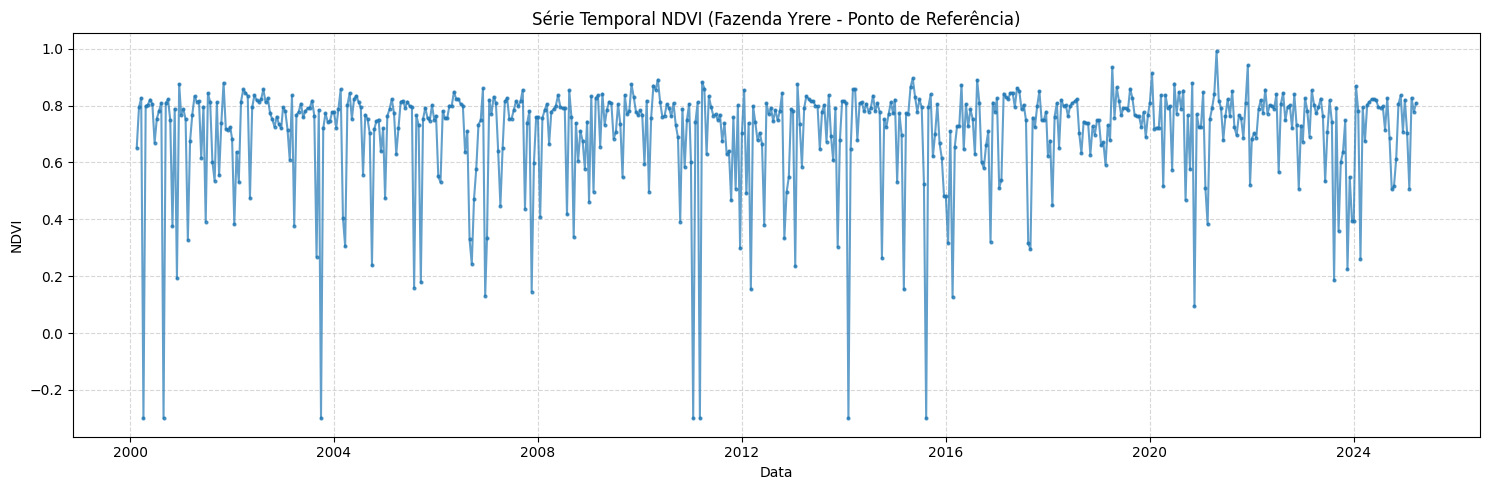

In [121]:
print("\n--- Plotando Série Temporal NDVI ---")
if 'df_ndvi' in locals() and not df_ndvi.empty:
    plt.figure(figsize=(15, 5))
    plt.plot(df_ndvi['Data'], df_ndvi['NDVI'], marker='.', linestyle='-', markersize=4, alpha=0.7)
    plt.title('Série Temporal NDVI (Fazenda Yrere - Ponto de Referência)')
    plt.xlabel('Data')
    plt.ylabel('NDVI')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    # Salve este gráfico como imagem (ex: 'ndvi_timeseries.png') e adicione ao README
else:
    print("DataFrame df_ndvi não disponível ou vazio para plotar.")

- Gerando Pairplot


--- Gerando Pairplot (Pode demorar um pouco) ---


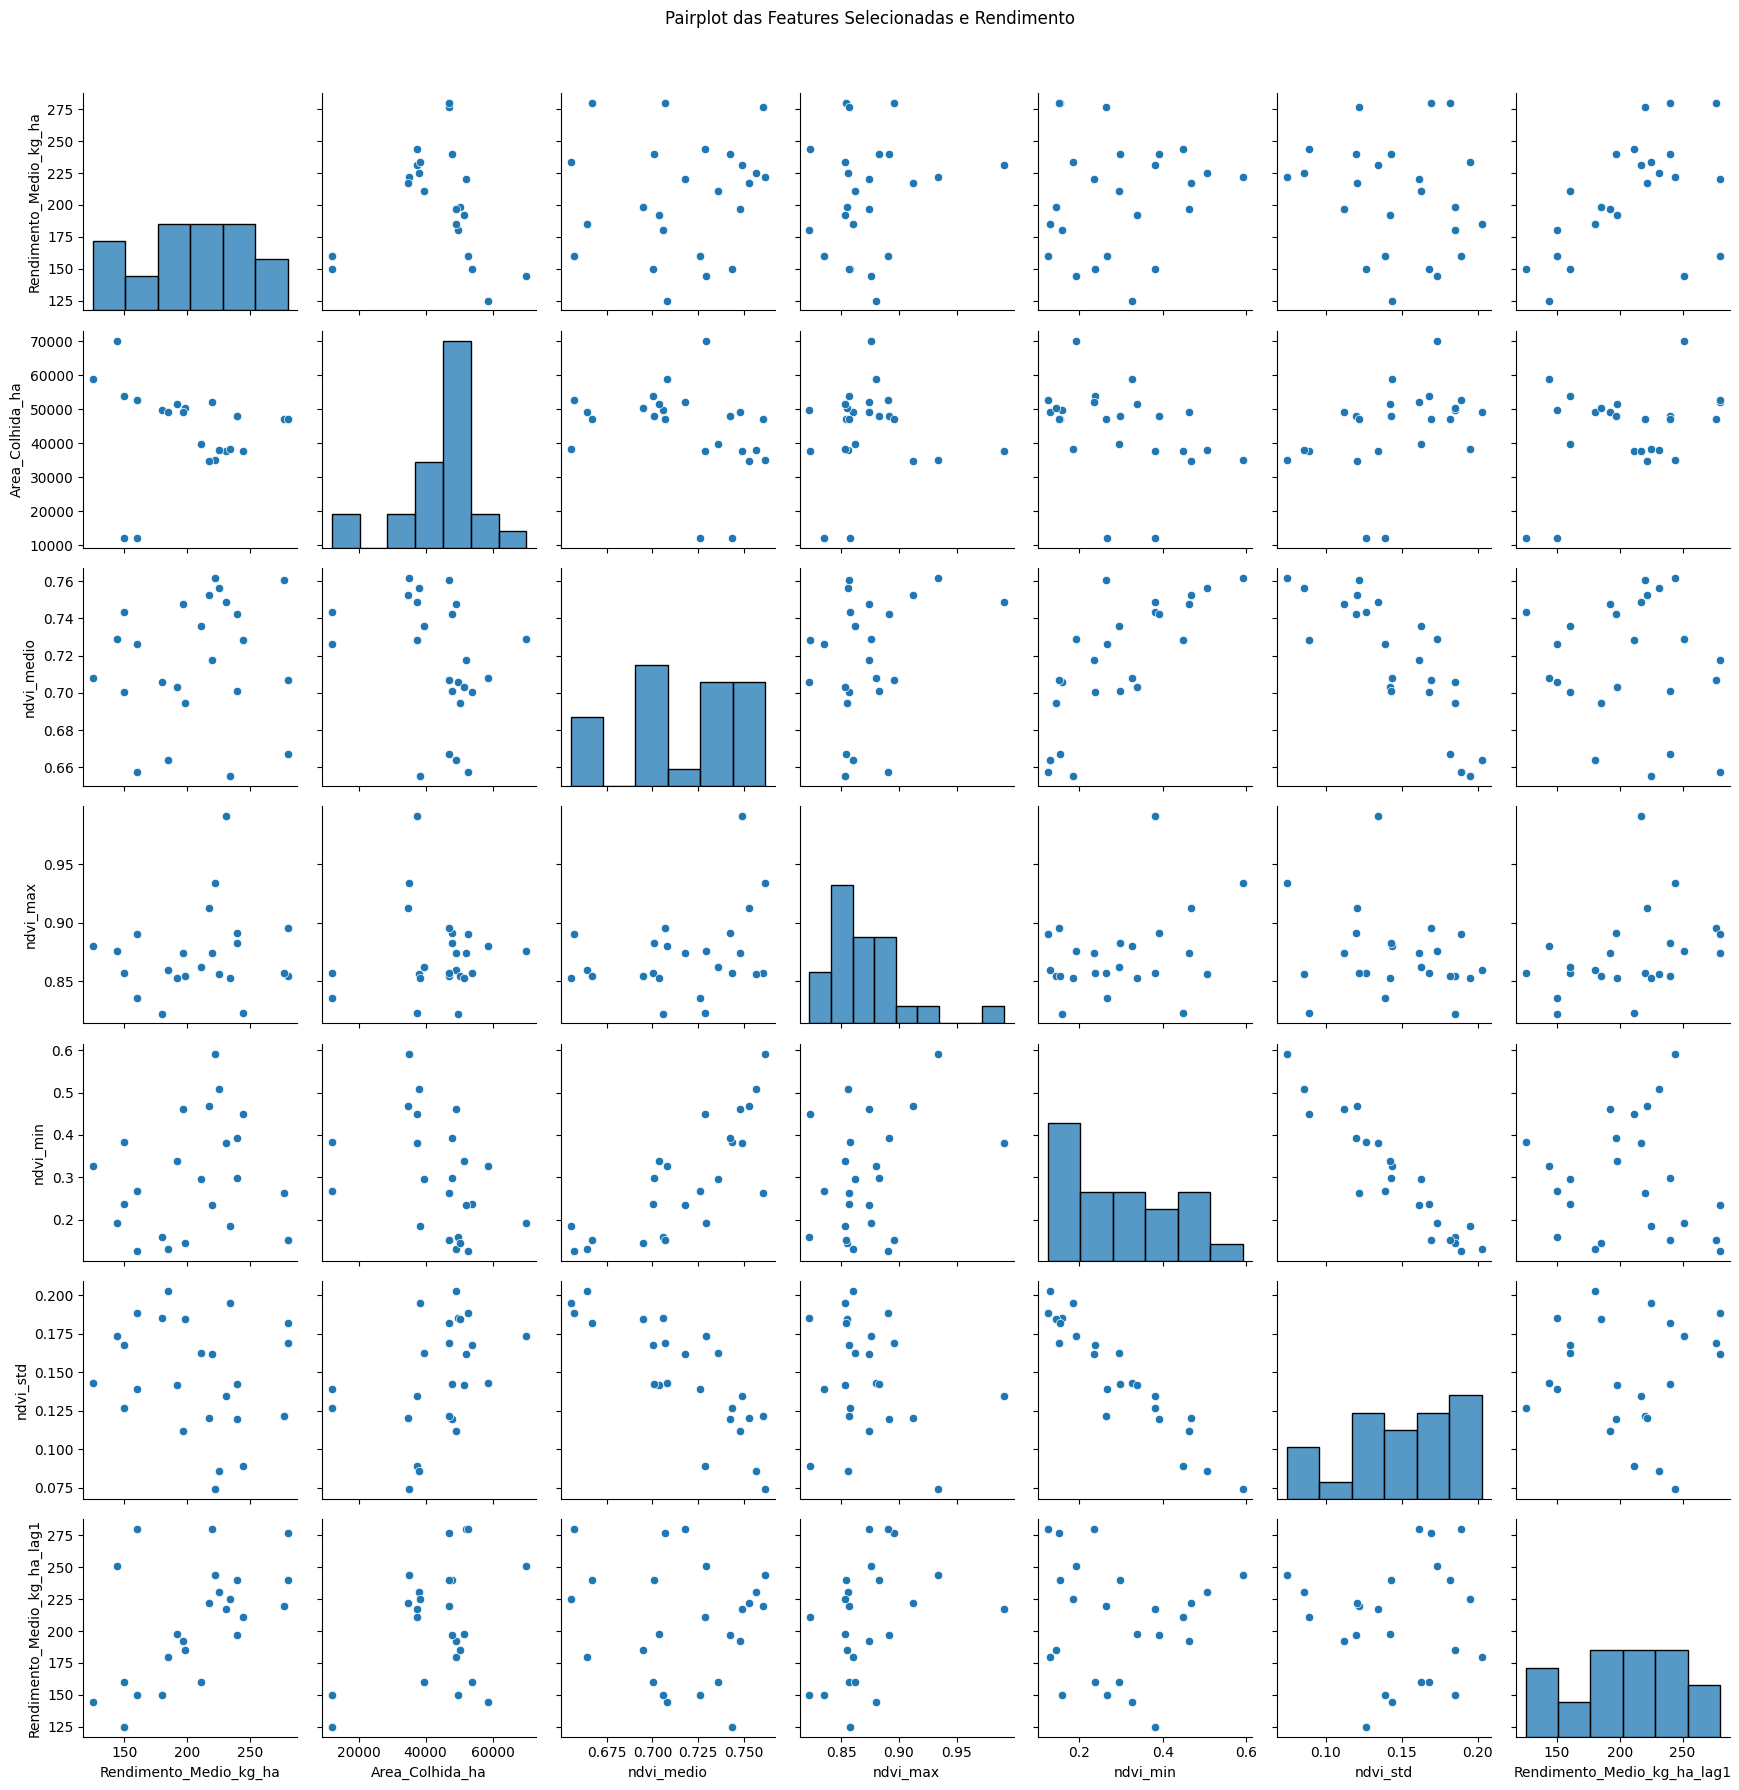

In [122]:
# Adicionar esta célula após criar df_final_cleaned
print("\n--- Gerando Pairplot (Pode demorar um pouco) ---")
if 'df_final_cleaned' in locals() and not df_final_cleaned.empty:
    # Selecionar colunas para o pairplot (pode escolher menos se ficar muito cheio)
    cols_for_pairplot = ['Rendimento_Medio_kg_ha', 'Area_Colhida_ha', 'ndvi_medio', 'ndvi_max', 'ndvi_min', 'ndvi_std', 'Rendimento_Medio_kg_ha_lag1']
    cols_exist_pairplot = [col for col in cols_for_pairplot if col in df_final_cleaned.columns]

    if len(cols_exist_pairplot) > 1:
        sns.pairplot(df_final_cleaned[cols_exist_pairplot])
        plt.suptitle('Pairplot das Features Selecionadas e Rendimento', y=1.02) # Título acima
        plt.tight_layout()
        plt.show()
        # Salve este gráfico como imagem (ex: 'pairplot.png') e adicione ao README
    else:
        print("Não há colunas suficientes para gerar o pairplot.")
else:
    print("DataFrame df_final_cleaned não disponível ou vazio para gerar pairplot.")


--- Limpando df_final (removendo linhas com NaN) ---
Shape após a limpeza: (24, 10)
Verificando NaNs restantes:
Ano                            0
Area_Colhida_ha                0
Rendimento_Medio_kg_ha         0
ndvi_medio                     0
ndvi_max                       0
ndvi_min                       0
ndvi_std                       0
ndvi_count                     0
Rendimento_Medio_kg_ha_lag1    0
Area_Colhida_ha_lag1           0
dtype: int64

--- Calculando Matriz de Correlação ---

Matriz de Correlação:
                             Area_Colhida_ha  Rendimento_Medio_kg_ha  \
Area_Colhida_ha                     1.000000               -0.066868   
Rendimento_Medio_kg_ha             -0.066868                1.000000   
ndvi_medio                         -0.315377                0.109921   
ndvi_max                            0.024880                0.154130   
ndvi_min                           -0.384990                0.090492   
ndvi_std                            0.388812     

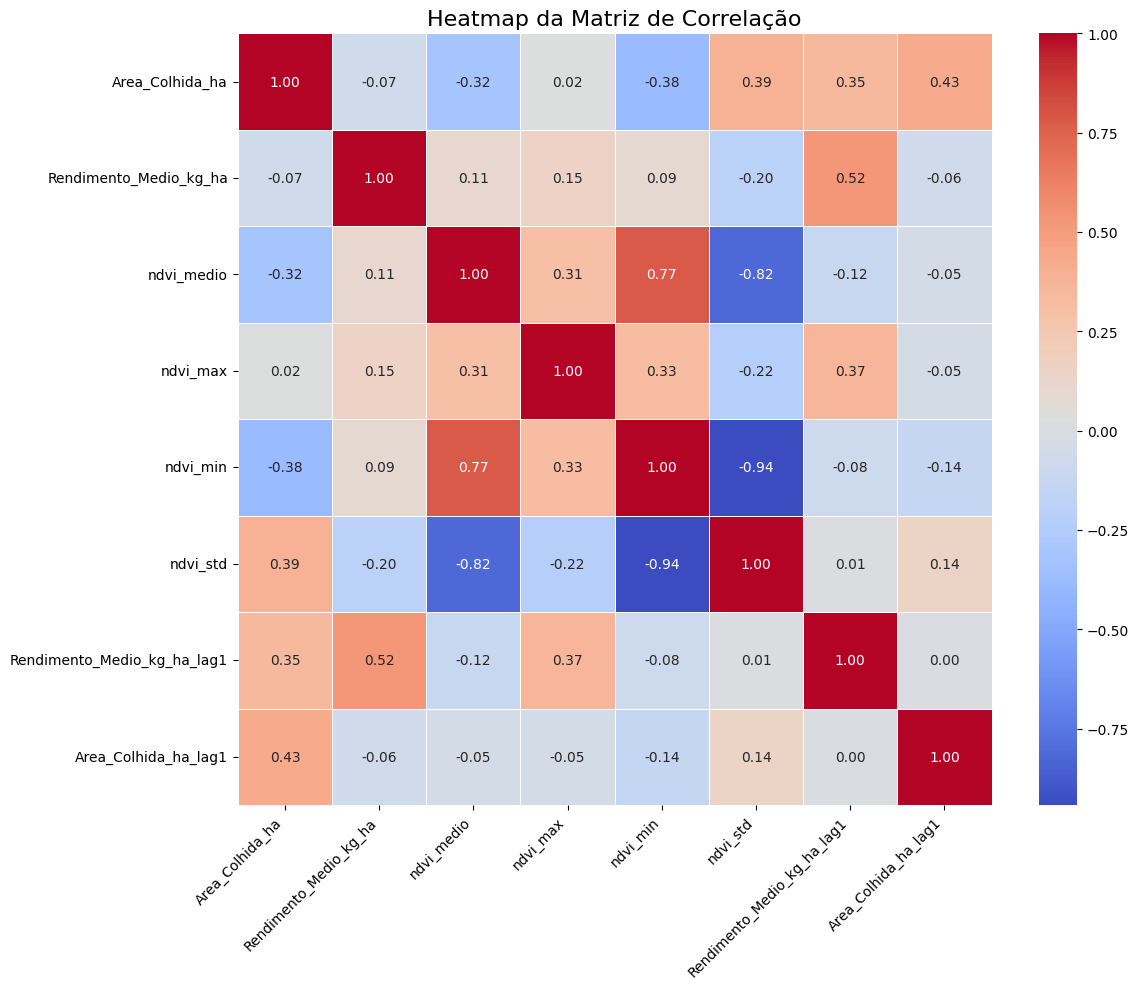


--- Correlação com Rendimento_Medio_kg_ha ---
Rendimento_Medio_kg_ha         1.000000
Rendimento_Medio_kg_ha_lag1    0.523068
ndvi_max                       0.154130
ndvi_medio                     0.109921
ndvi_min                       0.090492
Area_Colhida_ha_lag1          -0.064262
Area_Colhida_ha               -0.066868
ndvi_std                      -0.196863
Name: Rendimento_Medio_kg_ha, dtype: float64


In [123]:
# Célula para Análise de Correlação e Geração do Heatmap
# --- Pré-requisito: DataFrame 'df_final' ---
# Certifique-se de que o DataFrame 'df_final' existe e foi criado
# corretamente na célula anterior (com merge e features lagged).
# Exemplo de como ele deve estar antes desta célula:
# print(df_final.head())
# print(df_final.info())

# --- Limpeza Final (Remover NaNs) ---
# Garante que estamos trabalhando com dados completos para correlação
if 'df_final' in locals() and isinstance(df_final, pd.DataFrame):
    print("--- Limpando df_final (removendo linhas com NaN) ---")
    df_final_cleaned = df_final.dropna().copy()
    print(f"Shape após a limpeza: {df_final_cleaned.shape}")
    if df_final_cleaned.empty:
        print("Aviso: DataFrame ficou vazio após remover NaNs. Não é possível gerar heatmap.")
    else:
        print("Verificando NaNs restantes:")
        print(df_final_cleaned.isnull().sum())

        # --- Análise de Correlação ---
        print("\n--- Calculando Matriz de Correlação ---")
        # Selecionar colunas numéricas relevantes para a correlação
        # (Excluir 'Ano' e talvez 'ndvi_count' se não for relevante como preditor direto)
        cols_for_corr = [
            'Area_Colhida_ha',
            'Rendimento_Medio_kg_ha', # Alvo
            'ndvi_medio',
            'ndvi_max',
            'ndvi_min',
            'ndvi_std',
            'Rendimento_Medio_kg_ha_lag1', # Feature Lagged
            'Area_Colhida_ha_lag1'         # Feature Lagged
            # 'ndvi_count' # Descomente se quiser incluir
        ]
        # Garantir que as colunas existem no dataframe limpo
        cols_exist = [col for col in cols_for_corr if col in df_final_cleaned.columns]

        if len(cols_exist) > 1:
            correlation_matrix = df_final_cleaned[cols_exist].corr()

            print("\nMatriz de Correlação:")
            print(correlation_matrix)

            # --- Visualização: Gerar o Heatmap ---
            print("\n--- Gerando Heatmap da Matriz de Correlação ---")
            plt.figure(figsize=(12, 10)) # Ajuste o tamanho se necessário
            sns.heatmap(correlation_matrix,
                        annot=True,       # Mostrar os valores de correlação no mapa
                        cmap='coolwarm',  # Escolher um mapa de cores (ex: coolwarm, viridis, plasma)
                        fmt=".2f",        # Formatar os números para 2 casas decimais
                        linewidths=.5)    # Adicionar linhas entre as células
            plt.title('Heatmap da Matriz de Correlação', fontsize=16)
            plt.xticks(rotation=45, ha='right') # Rotacionar labels do eixo X para melhor leitura
            plt.yticks(rotation=0)
            plt.tight_layout() # Ajustar layout
            plt.show() # Exibe o gráfico

            # --- Opcional: Mostrar correlação específica com o alvo ---
            if 'Rendimento_Medio_kg_ha' in correlation_matrix.columns:
               print("\n--- Correlação com Rendimento_Medio_kg_ha ---")
               corr_with_target = correlation_matrix['Rendimento_Medio_kg_ha'].sort_values(ascending=False)
               print(corr_with_target)

        else:
            print("Não há colunas suficientes ou válidas para calcular a correlação.")
else:
    print("Erro: DataFrame 'df_final' não encontrado. Execute a célula de integração de dados primeiro.")

# Manter o dataframe limpo para as próximas etapas (se sobrescrever df_final)
# Se você usou df_final_cleaned no código de modelagem, não precisa desta linha
# df_final = df_final_cleaned

In [124]:
# Célula Intermediária: Preparar X, y e Dividir Treino/Teste

# Verificar se df_final_cleaned existe da célula anterior
if 'df_final_cleaned' in locals() and isinstance(df_final_cleaned, pd.DataFrame) and not df_final_cleaned.empty:
    print("\n--- Preparando X, y e Dividindo Treino/Teste ---")
    # Definir Features (X) e Target (y)
    target = 'Rendimento_Medio_kg_ha'
    # Incluir todas as colunas exceto 'Ano' e o próprio target
    features = [col for col in df_final_cleaned.columns if col != target and col != 'Ano']

    # Garantir que o target e todas as features existem
    if target in df_final_cleaned.columns and all(f in df_final_cleaned.columns for f in features):
        X = df_final_cleaned[features]
        y = df_final_cleaned[target]
        print(f"Features (X) selecionadas: {features}")
        print(f"Target (y) selecionado: {target}")
        print(f"Shape de X: {X.shape}, Shape de y: {y.shape}")

        # Divisão Temporal Treino/Teste Manual
        # TEST_YEARS_SPLIT deve ser definido na Célula 1 (ex: 5)
        split_index = len(X) - TEST_YEARS_SPLIT
        print(f"Índice de divisão calculado: {split_index} (Total Linhas: {len(X)}, Anos Teste: {TEST_YEARS_SPLIT})")

        if split_index > 0 and TEST_YEARS_SPLIT > 0 :
            # ** ESTA É A PARTE QUE CRIA AS VARIÁVEIS **
            X_train, X_test = X[:split_index], X[split_index:]
            y_train, y_test = y[:split_index], y[split_index:]
            anos_train = df_final_cleaned['Ano'][:split_index].tolist()
            anos_test = df_final_cleaned['Ano'][split_index:].tolist()
            # *******************************************

            print(f"Shape de X_train: {X_train.shape}, Shape de y_train: {y_train.shape}")
            print(f"Shape de X_test: {X_test.shape}, Shape de y_test: {y_test.shape}")
            print(f"Divisão Temporal: Treino ({min(anos_train)}-{max(anos_train)}), Teste ({min(anos_test)}-{max(anos_test)})")
            print("Variáveis X_train, y_train, X_test, y_test criadas com sucesso.")

        else:
            print(f"Erro: Dados insuficientes ({len(X)} linhas) ou TEST_YEARS_SPLIT ({TEST_YEARS_SPLIT}) inválido para criar conjunto de teste.")
            X_train, X_test, y_train, y_test, anos_test = None, None, None, None, None # Define como None

    else:
        print("Erro: Coluna target ou alguma coluna de feature não encontrada no DataFrame.")
        X_train, X_test, y_train, y_test, anos_test = None, None, None, None, None # Define como None

else:
    print("\n--- Preparação X/y/Split pulada: df_final_cleaned não disponível ou vazio. ---")
    X_train, X_test, y_train, y_test, anos_test = None, None, None, None, None # Garante que não existem


--- Preparando X, y e Dividindo Treino/Teste ---
Features (X) selecionadas: ['Area_Colhida_ha', 'ndvi_medio', 'ndvi_max', 'ndvi_min', 'ndvi_std', 'ndvi_count', 'Rendimento_Medio_kg_ha_lag1', 'Area_Colhida_ha_lag1']
Target (y) selecionado: Rendimento_Medio_kg_ha
Shape de X: (24, 8), Shape de y: (24,)
Índice de divisão calculado: 14 (Total Linhas: 24, Anos Teste: 10)
Shape de X_train: (14, 8), Shape de y_train: (14,)
Shape de X_test: (10, 8), Shape de y_test: (10,)
Divisão Temporal: Treino (2000-2013), Teste (2014-2023)
Variáveis X_train, y_train, X_test, y_test criadas com sucesso.


Célula 12: Preparar Dados para Modelo de Rendimento e Dividir

In [125]:
# Célula 12: Treinar Múltiplos Modelos de Previsão de Rendimento

# Verificar se os dados de treino (X_train, y_train) existem da Célula 11
if 'X_train' in locals() and X_train is not None and 'y_train' in locals() and y_train is not None:

    print("\n--- Treinando Múltiplos Modelos para Previsão de Rendimento ---")

    # --- 1. Definir Modelos a serem Testados ---
    models_to_train = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(random_state=RANDOM_STATE),
        "Decision Tree": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "Random Forest": RandomForestRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_STATE, n_jobs=-1),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_STATE),
        "SVR": SVR(),
        "XGBoost": XGBRegressor(random_state=RANDOM_STATE)
    }

    trained_models = {} # Dicionário para guardar os modelos treinados

    # --- 2. Loop para Treinar cada Modelo ---
    for name, model in models_to_train.items():
        print(f"--- Treinando Modelo: {name} ---")
        start_train_time = time.time()
        try:
            # Treinar o modelo
            model.fit(X_train, y_train)
            trained_models[name] = model # Armazenar o modelo treinado
            train_time = time.time() - start_train_time
            print(f"Treinamento concluído em {train_time:.2f} segundos.")

        except Exception as e:
            print(f"Erro ao treinar o modelo {name}: {e}")
            # Não adiciona ao dicionário de modelos treinados se falhar

    print("\n--- Todos os modelos foram treinados. ---")

else:
    print("\n--- Treinamento de modelos pulado: Dados de treino não disponíveis (Execute a Célula 11). ---")
    trained_models = None # Indica que o treinamento não ocorreu


--- Treinando Múltiplos Modelos para Previsão de Rendimento ---
--- Treinando Modelo: Linear Regression ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: Ridge Regression ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: Decision Tree ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: Random Forest ---
Treinamento concluído em 0.25 segundos.
--- Treinando Modelo: Gradient Boosting ---
Treinamento concluído em 0.13 segundos.
--- Treinando Modelo: SVR ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: XGBoost ---
Treinamento concluído em 0.03 segundos.

--- Todos os modelos foram treinados. ---


Célula 13: Treinar Modelo de Previsão de Rendimento


--- Avaliando Modelos Treinados no Conjunto de Teste ---
--- Avaliando: Linear Regression ---
  RMSE: 56.0869
  MAE:  44.2024
  R²:   -2.0129
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Ridge Regression ---
  RMSE: 45.5651
  MAE:  30.9145
  R²:   -0.9885
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Decision Tree ---
  RMSE: 49.6910
  MAE:  44.8000
  R²:   -1.3649
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Random Forest ---
  RMSE: 37.6424
  MAE:  29.9345
  R²:   -0.3571
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Gradient Boosting ---
  RMSE: 40.0266
  MAE:  33.0905
  R²:   -0.5345
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: SVR ---
  RMSE: 52.8446
  MAE:  47.5252
  R²:   -1.6746
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: XGBoost ---
  RMSE: 36.0876
  MAE:  29.9405
  R²:   -0.2473
  (Atenção: R² negativo indica desempe

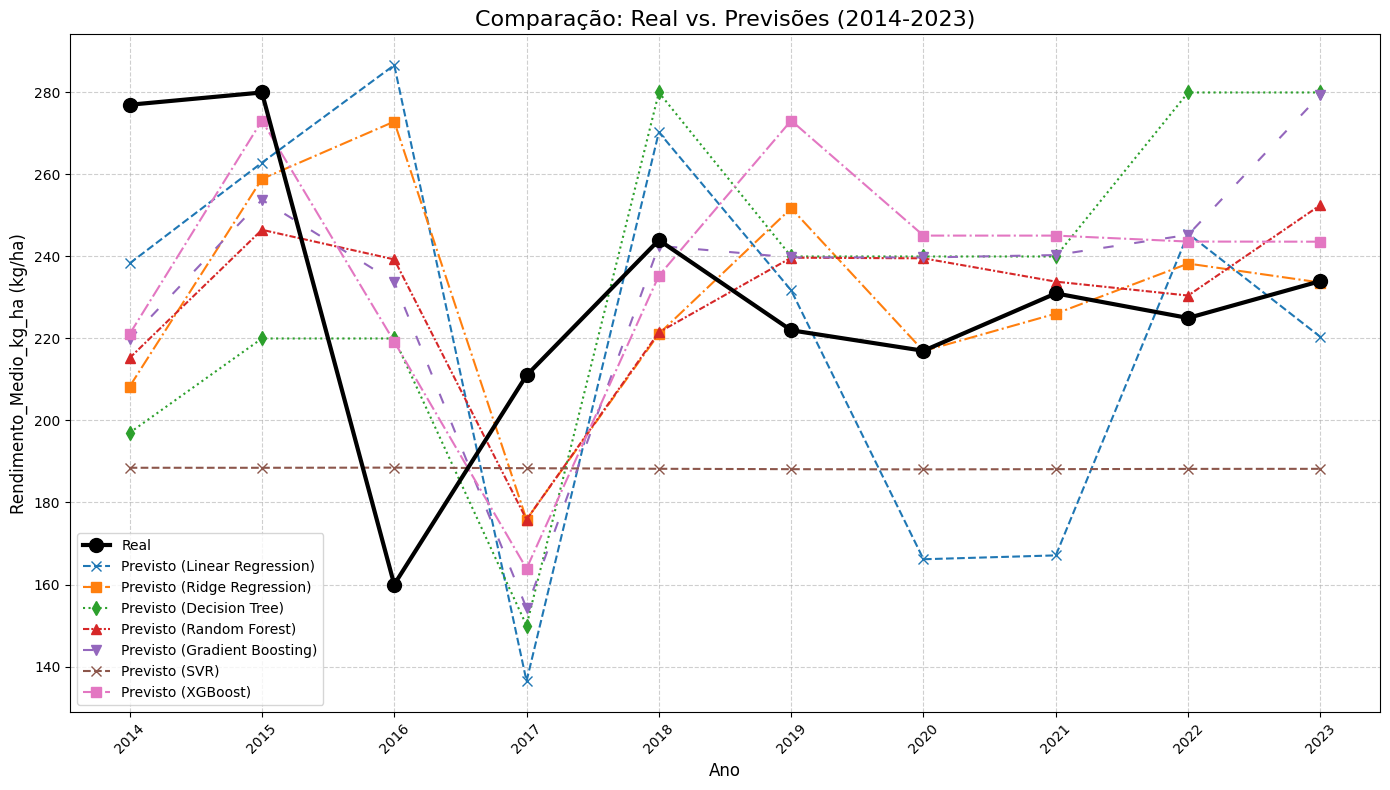

In [126]:
# Célula 13: Avaliar e Visualizar Modelos de Rendimento

# Verificar se modelos foram treinados e se há dados de teste
if 'trained_models' in locals() and trained_models is not None and \
   'X_test' in locals() and X_test is not None and \
   'y_test' in locals() and y_test is not None and \
   'anos_test' in locals() and anos_test is not None:

    print("\n--- Avaliando Modelos Treinados no Conjunto de Teste ---")

    results = {} # Dicionário para guardar resultados
    predictions = {} # Dicionário para guardar previsões

    # Loop pelos modelos treinados
    for name, model in trained_models.items():
        print(f"--- Avaliando: {name} ---")
        try:
            # Fazer Previsões
            start_pred_time = time.time()
            y_pred = model.predict(X_test)
            pred_time = time.time() - start_pred_time
            predictions[name] = y_pred # Guardar previsões

            # Calcular Métricas
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Guardar resultados
            results[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'PredTime': pred_time}

            # Imprimir métricas individuais
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")
            # Lembrar da interpretação do R² negativo!
            if r2 < 0:
                print("  (Atenção: R² negativo indica desempenho ruim no teste)")

        except Exception as e:
            print(f"Erro ao avaliar o modelo {name}: {e}")
            results[name] = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan, 'PredTime': np.nan}


    # --- Comparar Resultados ---
    if results: # Verifica se o dicionário não está vazio
        print("\n--- Comparativo de Resultados dos Modelos ---")
        results_df = pd.DataFrame(results).T # Transpor para ter modelos nas linhas
        print(results_df.sort_values(by='R2', ascending=False)) # Ordenar pelo R²
    else:
        print("Nenhum resultado de modelo para comparar.")

    # --- Visualizar Resultados (Previsto vs Real - Múltiplos Modelos) ---
    if predictions: # Verifica se há previsões para plotar
        print("\n--- Gerando Gráfico Comparativo Previsto vs Real ---")
        plt.figure(figsize=(14, 8))
        plt.plot(anos_test, y_test, label='Real', marker='o', linewidth=3, markersize=10, color='black', zorder=10) # Real na frente

        # Plotar previsões de cada modelo
        linestyles = ['--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
        style_idx = 0
        markers = ['x', 's', 'd', '^', 'v'] # Marcadores diferentes
        for name, y_pred in predictions.items():
            if y_pred is not None:
                style = linestyles[style_idx % len(linestyles)]
                marker = markers[style_idx % len(markers)]
                plt.plot(anos_test, y_pred, label=f'Previsto ({name})', marker=marker, linestyle=style, markersize=7)
                style_idx += 1

        plt.xlabel('Ano', fontsize=12)
        # Obter nome da coluna alvo dinamicamente se possível
        target_col_name = y_test.name if hasattr(y_test, 'name') else 'Rendimento Médio'
        plt.ylabel(f'{target_col_name} (kg/ha)', fontsize=12)
        plt.title(f'Comparação: Real vs. Previsões ({min(anos_test)}-{max(anos_test)})', fontsize=16)
        plt.legend(fontsize=10, loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(anos_test, rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma previsão disponível para plotar.")

else:
    print("\n--- Avaliação/Visualização pulada: Modelos ou dados de teste não disponíveis. ---")

Célula 14: Avaliar e Visualizar Modelo de Rendimento


--- Análise de Importância/Coeficientes das Features ---

--- Modelo: Linear Regression ---
Coeficientes:
                       Feature  Coefficient
4                     ndvi_std -1889.817199
1                   ndvi_medio  -715.538713
3                     ndvi_min  -351.205464
2                     ndvi_max  -177.135950
5                   ndvi_count    14.309855
6  Rendimento_Medio_kg_ha_lag1     0.802795
0              Area_Colhida_ha    -0.000376
7         Area_Colhida_ha_lag1     0.000329


<ipython-input-127-da3975a58dd7>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


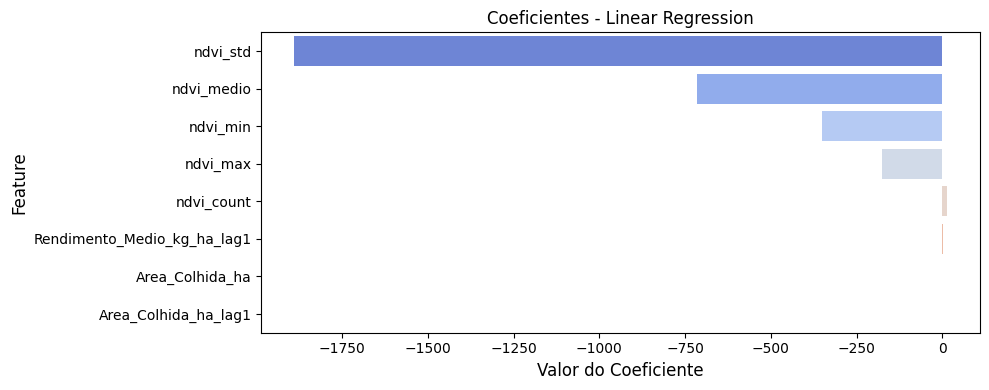


--- Modelo: Ridge Regression ---
Coeficientes:
                       Feature  Coefficient
5                   ndvi_count    15.477877
3                     ndvi_min    -2.312438
1                   ndvi_medio    -1.948095
6  Rendimento_Medio_kg_ha_lag1     0.891828
4                     ndvi_std     0.287162
2                     ndvi_max    -0.272548
0              Area_Colhida_ha    -0.000754
7         Area_Colhida_ha_lag1     0.000107


<ipython-input-127-da3975a58dd7>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')


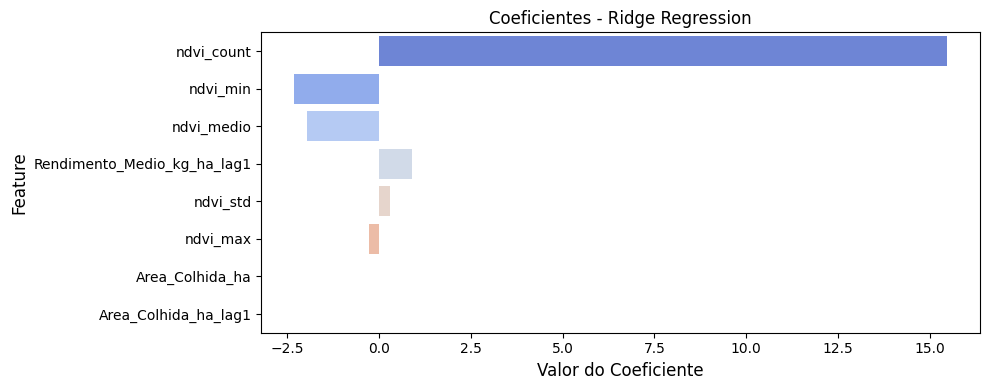


--- Modelo: Decision Tree ---
Importância das Features:
                       Feature  Importance
6  Rendimento_Medio_kg_ha_lag1    0.433049
7         Area_Colhida_ha_lag1    0.343849
2                     ndvi_max    0.106693
5                   ndvi_count    0.080520
4                     ndvi_std    0.032411
3                     ndvi_min    0.003457
1                   ndvi_medio    0.000020
0              Area_Colhida_ha    0.000000


<ipython-input-127-da3975a58dd7>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


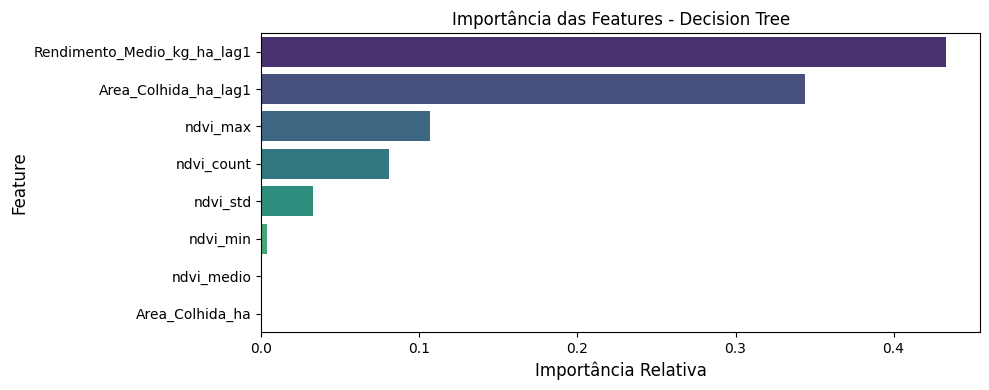


--- Modelo: Random Forest ---
Importância das Features:
                       Feature  Importance
6  Rendimento_Medio_kg_ha_lag1    0.338396
7         Area_Colhida_ha_lag1    0.222913
0              Area_Colhida_ha    0.186025
2                     ndvi_max    0.125573
1                   ndvi_medio    0.061499
3                     ndvi_min    0.027866
4                     ndvi_std    0.022337
5                   ndvi_count    0.015393


<ipython-input-127-da3975a58dd7>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


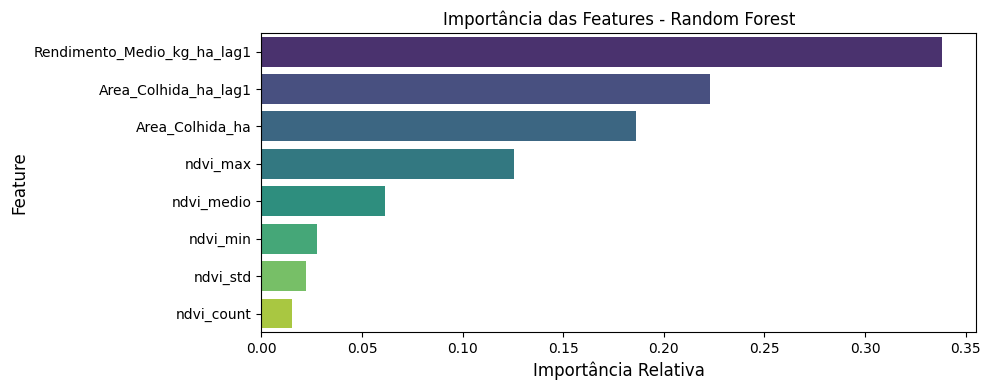


--- Modelo: Gradient Boosting ---
Importância das Features:
                       Feature  Importance
6  Rendimento_Medio_kg_ha_lag1    0.436332
7         Area_Colhida_ha_lag1    0.225230
0              Area_Colhida_ha    0.157811
2                     ndvi_max    0.059436
4                     ndvi_std    0.048264
3                     ndvi_min    0.038022
5                   ndvi_count    0.025548
1                   ndvi_medio    0.009357


<ipython-input-127-da3975a58dd7>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


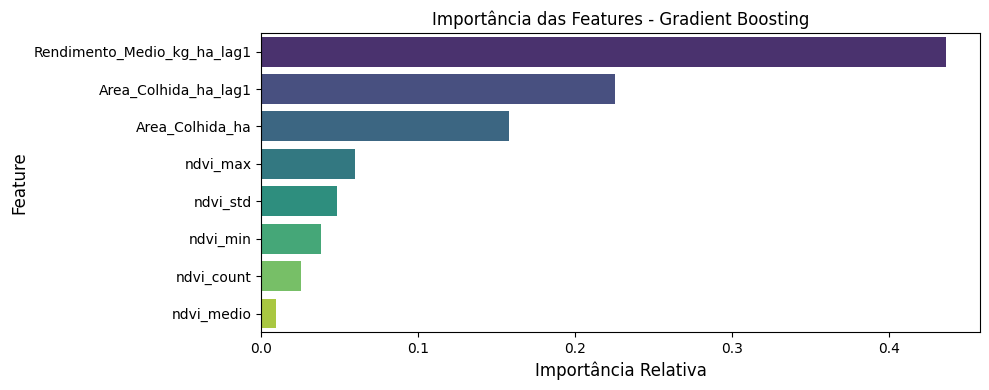


--- Modelo: SVR ---
Este modelo não possui um atributo padrão '.feature_importances_' ou '.coef_' para análise direta.

--- Modelo: XGBoost ---
Importância das Features:
                       Feature    Importance
6  Rendimento_Medio_kg_ha_lag1  5.131624e-01
7         Area_Colhida_ha_lag1  2.668520e-01
3                     ndvi_min  1.289614e-01
0              Area_Colhida_ha  7.535265e-02
2                     ndvi_max  1.249169e-02
1                   ndvi_medio  3.179829e-03
5                   ndvi_count  2.884767e-09
4                     ndvi_std  0.000000e+00


<ipython-input-127-da3975a58dd7>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


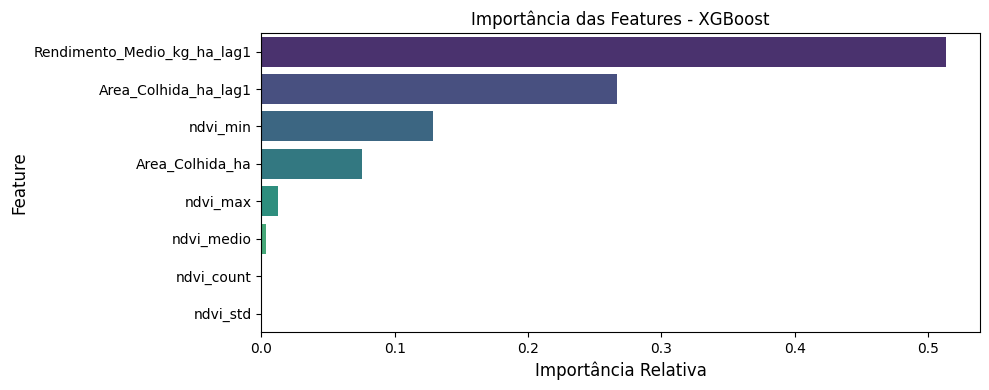


--- Fim da Análise de Modelos ---


In [127]:
# Célula 14: Importância das Features / Coeficientes (Adaptada para Múltiplos Modelos)

# Verificar se o dicionário de modelos treinados e a lista de features existem
# 'features' deve ter sido definida na Célula 11.5 (Preparar X/y/Split)
if 'trained_models' in locals() and trained_models is not None and \
   'features' in locals() and features is not None:

    print("\n--- Análise de Importância/Coeficientes das Features ---")

    # Loop pelos modelos que foram treinados com sucesso
    for name, model in trained_models.items():
        print(f"\n--- Modelo: {name} ---")
        try:
            # Checar se o modelo tem o atributo feature_importances_ (árvores, ensembles)
            if hasattr(model, 'feature_importances_'):
                print("Importância das Features:")
                importances = model.feature_importances_
                # Criar dataframe de importância
                feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
                feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
                print(feature_importance_df)

                # Plotar importância para este modelo
                plt.figure(figsize=(10, max(4, len(features)*0.5))) # Ajustar altura
                # Passar 'hue' pode causar erro se não for categórico ou se quiser uma cor só
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
                plt.title(f'Importância das Features - {name}')
                plt.xlabel('Importância Relativa', fontsize=12)
                plt.ylabel('Feature', fontsize=12)
                plt.tight_layout()
                plt.show()

            # Checar se o modelo tem o atributo coef_ (modelos lineares)
            elif hasattr(model, 'coef_'):
                print("Coeficientes:")
                # Garantir que 'features' tem o mesmo tamanho que model.coef_
                if len(features) == len(model.coef_):
                   coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
                   # Ordenar pelo valor absoluto do coeficiente
                   coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
                   print(coef_df)

                   # Plotar coeficientes
                   plt.figure(figsize=(10, max(4, len(features)*0.5)))
                   sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='coolwarm')
                   plt.title(f'Coeficientes - {name}')
                   plt.xlabel('Valor do Coeficiente', fontsize=12)
                   plt.ylabel('Feature', fontsize=12)
                   plt.tight_layout()
                   plt.show()
                else:
                    # Isso pode acontecer se o modelo linear adiciona um intercepto separadamente
                    print(f"  Aviso: Número de features ({len(features)}) não corresponde ao número de coeficientes ({len(model.coef_)}). Verifique o intercepto.")
                    # Imprimir apenas os coeficientes brutos neste caso
                    print(f"  Coeficientes brutos: {model.coef_}")
                    if hasattr(model, 'intercept_'):
                        print(f"  Intercepto: {model.intercept_}")

            # Adicionar aqui 'elif' para outros tipos de análise se necessário (ex: SVR)
            else:
                print("Este modelo não possui um atributo padrão '.feature_importances_' ou '.coef_' para análise direta.")

        except Exception as e:
            print(f"Erro ao obter/plotar importância/coeficientes para {name}: {e}")

else:
    print("\n--- Análise de importância pulada: Dicionário 'trained_models' ou lista 'features' não disponíveis. ---")

print("\n--- Fim da Análise de Modelos ---")

Célula 15: Retreinar Modelos Finais com Todos os Dados Históricos

In [ ]:
# Célula 15: Retreinar Modelos Finais com Todos os Dados Históricos

# --- Pré-requisitos ---
# df_final_cleaned: DataFrame limpo com dados históricos (ex: 2001-2023) - Nome CORRETO
# features: Lista com os nomes das colunas de features
# target: String com o nome da coluna alvo
# models_to_train: Dicionário definido na Célula 12 com os modelos a instanciar
# RANDOM_STATE, N_ESTIMATORS_RF: Constantes definidas na Célula 1

final_trained_models = {} # Dicionário para guardar os modelos finais

# Verificar se os dados e definições existem usando o nome correto
if 'df_final_cleaned' in locals() and isinstance(df_final_cleaned, pd.DataFrame) and not df_final_cleaned.empty and \
   'features' in locals() and isinstance(features, list) and \
   'target' in locals() and isinstance(target, str) and \
   'models_to_train' in locals() and isinstance(models_to_train, dict):

    print(f"\n--- Retreinando modelos finais com dados de {df_final_cleaned['Ano'].min()} a {df_final_cleaned['Ano'].max()} ---")

    # Preparar X_full e y_full usando o nome correto
    X_full = df_final_cleaned[features]
    y_full = df_final_cleaned[target]
    print(f"Usando {X_full.shape[0]} amostras e {X_full.shape[1]} features.")

    # Loop para treinar cada modelo
    for name, model_instance in models_to_train.items():
        print(f"--- Retreinando: {name} ---")
        start_train_time = time.time()
        try:
            final_model = model_instance.__class__(**model_instance.get_params()) # Re-instancia
            if 'random_state' in final_model.get_params(): final_model.set_params(random_state=RANDOM_STATE)
            if 'n_jobs' in final_model.get_params(): final_model.set_params(n_jobs=-1)

            final_model.fit(X_full, y_full)
            final_trained_models[name] = final_model

            # --- DEBUG PRINT 1: Verificar o tipo (opcional) ---
            # print(f"DEBUG: Armazenado para '{name}'. Tipo: {type(final_model)}")
            # -------------------------------------------------

            train_time = time.time() - start_train_time
            print(f"Treinamento concluído em {train_time:.2f} segundos.")

        except Exception as e:
            print(f"Erro ao retreinar o modelo {name}: {e}")

    print(f"\n--- Modelos finais retreinados: {list(final_trained_models.keys())} ---")

    # --- DEBUG PRINT 2: Verificar o conteúdo final (opcional) ---
    # print("\nDEBUG: Conteúdo final de 'final_trained_models':")
    # print(final_trained_models)
    # ----------------------------------------------------------

else:
    print("Erro: Não foi possível retreinar os modelos. Verifique se df_final_cleaned, features, target e models_to_train estão definidos.")
    final_trained_models = None


--- Retreinando modelos finais com dados de 2000 a 2023 ---
Usando 24 amostras e 8 features.
--- Retreinando: Linear Regression ---
Treinamento concluído em 0.00 segundos.
--- Retreinando: Ridge Regression ---
Treinamento concluído em 0.00 segundos.
--- Retreinando: Decision Tree ---
Treinamento concluído em 0.00 segundos.
--- Retreinando: Random Forest ---
Treinamento concluído em 0.25 segundos.
--- Retreinando: Gradient Boosting ---
Treinamento concluído em 0.14 segundos.
--- Retreinando: SVR ---
Treinamento concluído em 0.00 segundos.
--- Retreinando: XGBoost ---
Treinamento concluído em 0.03 segundos.

--- Modelos finais retreinados: ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVR', 'XGBoost'] ---


Célula 16: Estimar Features para o Ano Futuro (Ex: 2024)

In [ ]:
# Célula 16: Estimar Features para o Ano Futuro (Ex: 2024) (CORRIGIDO)

# --- Pré-requisitos ---
# df_final_cleaned: DataFrame com dados históricos até o último ano (ex: 2023) - Nome CORRETO
# features: Lista com os nomes das colunas de features (na ordem correta!)
# X_full: DataFrame de features usado no retreino final (para pegar a ordem das colunas)

X_future_2024 = None # Inicializa

# Usar o nome correto na verificação
if 'df_final_cleaned' in locals() and not df_final_cleaned.empty and 'X_full' in locals():
    print("\n--- Estimando/Preparando Features para Previsão de 2024 ---")
    print("*** ATENÇÃO: Os valores abaixo para features não-lagged são EXEMPLOS/CHUTES! ***")
    print("*** Ajuste essas estimativas com base em sua análise ou cenários desejados! ***")

    try:
        # Usar o nome correto para pegar o último ano
        last_historical_year_data = df_final_cleaned.iloc[-1]
        last_historical_year_num = last_historical_year_data['Ano']
        print(f"Usando dados de {int(last_historical_year_num)} para gerar features lagged de 2024.")

        features_for_2024_dict = {}

        # 1. Features Lagged
        if 'Rendimento_Medio_kg_ha_lag1' in features:
             features_for_2024_dict['Rendimento_Medio_kg_ha_lag1'] = last_historical_year_data['Rendimento_Medio_kg_ha']
        if 'Area_Colhida_ha_lag1' in features:
             features_for_2024_dict['Area_Colhida_ha_lag1'] = last_historical_year_data['Area_Colhida_ha']

        # 2. Features Não-Lagged (ESTIMADAS!)
        # Usar o nome correto para calcular médias ou pegar últimos valores
        if 'Area_Colhida_ha' in features:
            features_for_2024_dict['Area_Colhida_ha'] = last_historical_year_data['Area_Colhida_ha'] # Ex: Repetir 2023
            print(f"Estimativa Area_Colhida_ha (2024): {features_for_2024_dict['Area_Colhida_ha']} (igual a {int(last_historical_year_num)})")

        ndvi_cols = [f for f in features if 'ndvi' in f and f not in ['Area_Colhida_ha_lag1', 'Rendimento_Medio_kg_ha_lag1']]
        for col in ndvi_cols:
           features_for_2024_dict[col] = df_final_cleaned[col].mean() # Ex: Média histórica
           print(f"Estimativa {col} (2024): {features_for_2024_dict[col]:.4f} (média histórica)")

        weather_cols = [f for f in features if 'precip_' in f or 'temp_' in f or 'umid_' in f]
        for col in weather_cols:
            features_for_2024_dict[col] = df_final_cleaned[col].mean() # Ex: Média histórica
            print(f"Estimativa {col} (2024): {features_for_2024_dict[col]:.4f} (média histórica)")

        # Criar DataFrame para 2024 com colunas na ordem correta
        X_future_2024 = pd.DataFrame([features_for_2024_dict])[X_full.columns]
        print("\nDataFrame com features estimadas para 2024 criado:")
        print(X_future_2024)

    except Exception as e:
        print(f"Erro ao estimar features futuras: {e}")
        X_future_2024 = None

else:
    print("Erro: Não foi possível estimar features futuras. Verifique df_final_cleaned e X_full.")


--- Estimando/Preparando Features para Previsão de 2024 ---
*** ATENÇÃO: Os valores abaixo para features não-lagged são EXEMPLOS/CHUTES! ***
*** Ajuste essas estimativas com base em sua análise ou cenários desejados! ***
Usando dados de 2023 para gerar features lagged de 2024.
Estimativa Area_Colhida_ha (2024): 38294.0 (igual a 2023)
Estimativa ndvi_medio (2024): 0.7173 (média histórica)
Estimativa ndvi_max (2024): 0.8729 (média histórica)
Estimativa ndvi_min (2024): 0.2976 (média histórica)
Estimativa ndvi_std (2024): 0.1468 (média histórica)
Estimativa ndvi_count (2024): 22.5417 (média histórica)

DataFrame com features estimadas para 2024 criado:
   Area_Colhida_ha  ndvi_medio  ndvi_max  ndvi_min  ndvi_std  ndvi_count  \
0          38294.0    0.717267  0.872867  0.297646   0.14683   22.541667   

   Rendimento_Medio_kg_ha_lag1  Area_Colhida_ha_lag1  
0                        234.0               38294.0  


Célula 17: Gerar e Visualizar Previsões para 2024 (Todos os Modelos)


--- Gerando Previsões para 2024 com Todos os Modelos ---
Erro ao gerar previsão para 2024 com Ano: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com Area_Colhida_ha: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com Rendimento_Medio_kg_ha: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com ndvi_medio: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com ndvi_max: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com ndvi_min: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com ndvi_std: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com ndvi_count: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com Rendimento_Medio_kg_ha_lag1: 'Series' object has no attribute 'predict'
Erro ao gerar previsão para 2024 com Area_Colhida_ha_lag1: 'Series' object has no attribute '

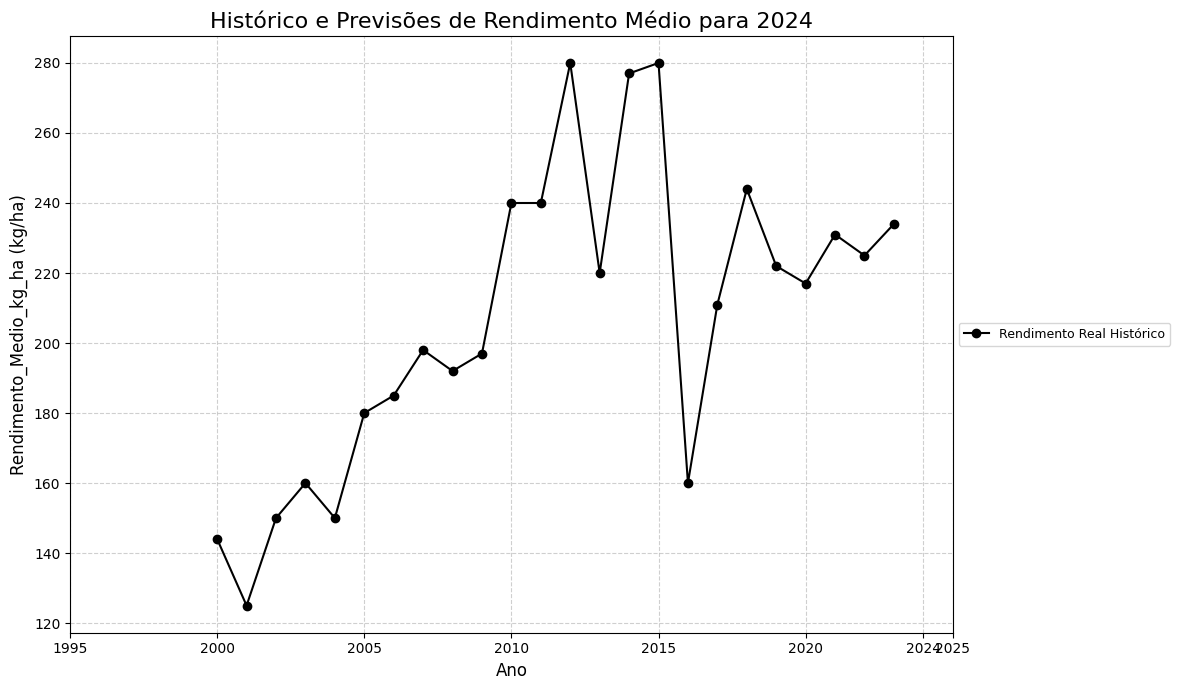

In [ ]:
# Célula 17: Gerar e Visualizar Previsões para 2024 (Todos os Modelos) (CORRIGIDO)

# --- Pré-requisitos ---
# final_trained_models: Dicionário com modelos retreinados (da Célula 15)
# X_future_2024: DataFrame com as features estimadas para 2024 (da Célula 16)
# df_final_cleaned: DataFrame com dados históricos (para plotar o histórico) - Nome CORRETO
# target: Nome da coluna alvo

forecasts_2024 = {} # Dicionário para guardar as previsões

# Usar nome correto na verificação
if 'final_trained_models' in locals() and final_trained_models is not None and \
   'X_future_2024' in locals() and X_future_2024 is not None:

    print("\n--- Gerando Previsões para 2024 com Todos os Modelos ---")

    # Loop pelos modelos finais treinados
    for name, model in final_trained_models.items():
        try:
            y_forecast_2024 = model.predict(X_future_2024)
            forecasts_2024[name] = y_forecast_2024[0]
            print(f"Previsão 2024 ({name}): {forecasts_2024[name]:.2f} kg/ha")
        except Exception as e:
            print(f"Erro ao gerar previsão para 2024 com {name}: {e}")
            forecasts_2024[name] = np.nan


    # --- Visualizar Histórico + Previsões ---
    # Usar nome correto na verificação
    if forecasts_2024 and 'df_final_cleaned' in locals() and not df_final_cleaned.empty:
        print("\n--- Gerando Gráfico: Histórico + Previsões 2024 ---")

        plt.figure(figsize=(14, 7))

        # Plotar histórico real usando nome correto
        plt.plot(df_final_cleaned['Ano'], df_final_cleaned[target], label='Rendimento Real Histórico', marker='o', color='black')

        # Plotar previsões para 2024
        ano_previsao = 2024
        markers = ['x', 's', 'd', '^', 'v', '*', 'P']
        marker_idx = 0
        for name, forecast in forecasts_2024.items():
            if not pd.isna(forecast):
                 marker = markers[marker_idx % len(markers)]
                 plt.scatter([ano_previsao], [forecast], label=f'Previsão 2024 ({name})', marker=marker, s=100, zorder=10)
                 marker_idx += 1

        plt.xlabel('Ano', fontsize=12)
        plt.ylabel(f'{target} (kg/ha)', fontsize=12)
        plt.title('Histórico e Previsões de Rendimento Médio para 2024', fontsize=16)
        plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid(True, linestyle='--', alpha=0.6)
        # Ajustar limites do eixo X
        plt.xlim(left=df_final_cleaned['Ano'].min() - 1, right=ano_previsao + 1)
        # Tentar adicionar 2024 ao eixo x de forma mais robusta
        current_ticks = list(plt.xticks()[0])
        if ano_previsao not in current_ticks:
             current_ticks.append(ano_previsao)
             current_ticks.sort()
             plt.xticks(ticks=current_ticks, rotation=45)
        else:
             plt.xticks(rotation=45)

        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta layout
        plt.show()

    else:
        print("Não foi possível gerar gráfico: Sem previsões ou sem dados históricos.")

else:
    print("\n--- Previsão para 2024 pulada: Modelos finais ou features futuras não disponíveis. ---")